In [1]:
# Importation des packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

# differentes Valeurs aberrantes
# 1- valeurs erronées
# 2- valeurs extremes

In [25]:
# Charger la base de données Boston Housing
#  1ere possibilité : H = pd.read_table('C:/Users/brech/Desktop/dossier de taff/ML/california.txt')
from  sklearn.datasets import fetch_california_housing
california = fetch_california_housing()
data = pd.DataFrame(california.data, columns=california.feature_names)
data['median_house_value'] = california.target
print(data.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  median_house_value  
0    -122.23               4.526  
1    -122.22               3.585  
2    -122.24               3.521  
3    -122.25               3.413  
4    -122.25               3.422  


In [21]:
# Afficher la description complète de la base
print(california.DESCR)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [23]:
# Examiner les caracteristiques (features):

# Noms des colonnes (features)
print("Features:", california.feature_names)

# Taille du dataset
print("Nombre d'échantillons:", california.data.shape[0])
print("Nombre de caractéristiques:", california.data.shape[1])


Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Nombre d'échantillons: 20640
Nombre de caractéristiques: 8


In [27]:
# Description de la base de données
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [29]:
# Regarder les min et les max et les quantiles pour voir s'il n'a pas de valeurs qui peuvent se voir à l'oeil

### 2 Identification graphique des outliers

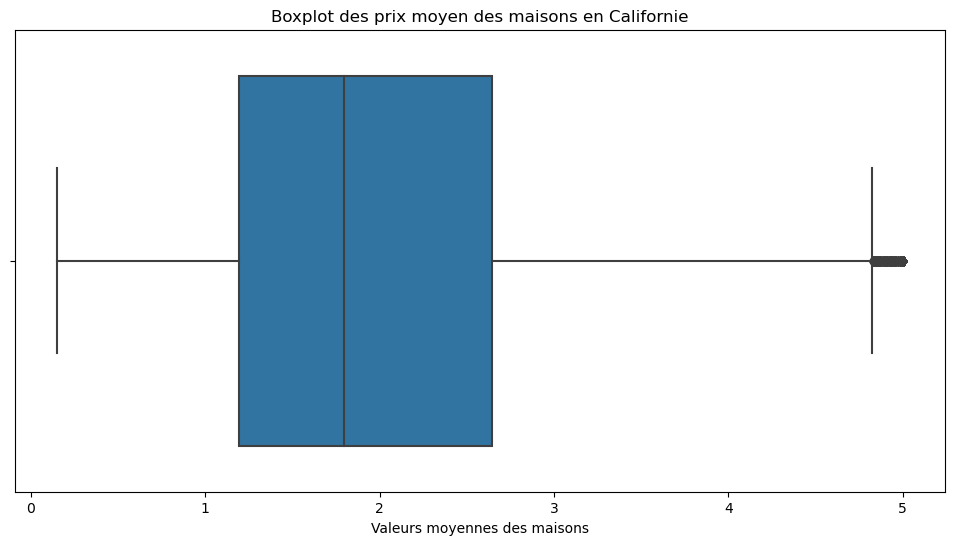

In [32]:
# Visualiser les outliers en utilisant un boxplot avec Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='median_house_value')
plt.xlabel('Valeurs moyennes des maisons')
plt.title('Boxplot des prix moyen des maisons en Californie')
plt.show()

## 1ere approche : Identification des outliers univariées
### Identification des outliers IQR
La méthode de l'IQR est une approche courante pour identifier les valeurs aberrantes dans des données univariées. Elle utilise l'écart interquartile pour définir une plage de valeurs plausibles et identifie les observations qui sont en dehors de cette plage.

### Définition
L'IQR est défini comme la différence entre le troisième quartile (Q3) et le premier quartile (Q1) de la distribution des données. Les bornes inférieure et supérieure de la plage plausible sont définies comme suit :

- Limite inférieure : Q1 - 1,5 x IQR
- Limite supérieure : Q3 + 1,5 x IQR
Les observations en dehors de ces bornes sont considérées comme des valeurs aberrantes.

### Avantages
La méthode de l'IQR est relativement simple à comprendre et à implémenter. Elle est également assez robuste aux valeurs aberrantes, car elle utilise la médiane et l'écart interquartile pour calculer les bornes plausibles.

### Inconvénients
La méthode de l'IQR peut ne pas fonctionner correctement dans certaines distributions non symétriques, car elle suppose une distribution normale ou presque normale des données. Elle peut également ne pas fonctionner correctement si les données contiennent de nombreux points de données aberrants.

In [36]:
# Identification des données aberrantes - IQR
# Fonction pour detecter les outliers en utilisant l'IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Trouver les outliers pour la colonne 'median_house_value'
outliers = detect_outliers_iqr(data, 'median_house_value')

# Afficher les outliers
print('Outliers détectés:')
print(outliers)

Outliers détectés:
        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
89      1.2434      52.0  2.929412   0.917647       396.0  4.658824     37.80   
140     6.3624      30.0  5.615385   0.730769       126.0  2.423077     37.81   
459     1.1696      52.0  2.436000   0.944000      1349.0  5.396000     37.87   
489     3.0417      48.0  4.690632   1.126362      1656.0  3.607843     37.86   
493     7.8521      52.0  7.794393   1.051402       517.0  2.415888     37.86   
...        ...       ...       ...        ...         ...       ...       ...   
20422   5.1457      35.0  6.958333   1.217593       576.0  2.666667     34.14   
20426  10.0472      11.0  9.890756   1.159664       415.0  3.487395     34.18   
20427   8.6499       4.0  7.236059   1.032528      5495.0  2.553439     34.19   
20436  12.5420      10.0  9.873315   1.102426      1179.0  3.177898     34.21   
20443   3.3438      50.0  5.342857   0.942857       130.0  3.714286     34.27   

       L

## 2eme approche : Identification des outliers avec Z-score

### 3.3 Méthode du z-score
La méthode du z-score est une autre approche courante pour identifier les valeurs aberrantes dans des données univariées. Elle utilise l'écart à la moyenne pour définir une plage de valeurs plausibles et identifie les observations qui sont en dehors de cette plage.

#### 3.3.1 Définition
Le z-score est défini comme la différence entre une observation et la moyenne de la distribution des données, divisée par l'écart-type de la distribution :

z = (x - μ) / σ

Les bornes inférieure et supérieure de la plage plausible sont définies comme suit :

- Limite inférieure : μ - 3 x σ
- Limite supérieure : μ + 3 x σ
Les observations en dehors de ces bornes sont considérées comme des valeurs aberrantes.

#### 3.3.2 Avantages

La méthode du z-score est également relativement simple à comprendre et à implémenter. Elle est également assez robuste aux valeurs aberrantes, car elle utilise la moyenne et l'écart-type pour calculer les bornes plausibles.

#### 3.3.3 Inconvénients
Comme pour la méthode de l'IQR, la méthode du z-score peut ne pas fonctionner correctement dans certaines distributions non symétriques. Elle peut également ne pas fonctionner correctement si les données contiennent de nombreux points de données aberrants.

In [41]:
# Identification des données aberrantes - z-score
# Fonction pour detecter les outliers en utilisant le z-score

def detect_outliers_zscore(data, column, threshold=2): # threshold represente le seuil, une autre valeur peut etre definie
    z_scores = (data[column] - data[column].mean()) / data[column].std()
    return data[np.abs(z_scores) > threshold] # abs pour la valeur absolue

# Trouver les outliers pour la colonne 'median_house_value'
outliers = detect_outliers_zscore(data, 'median_house_value')

# Afficher les outliers
print("Outliers detectés:")
print(outliers)

Outliers detectés:
        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0       8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
89      1.2434      52.0  2.929412   0.917647       396.0  4.658824     37.80   
140     6.3624      30.0  5.615385   0.730769       126.0  2.423077     37.81   
459     1.1696      52.0  2.436000   0.944000      1349.0  5.396000     37.87   
489     3.0417      48.0  4.690632   1.126362      1656.0  3.607843     37.86   
...        ...       ...       ...        ...         ...       ...       ...   
20422   5.1457      35.0  6.958333   1.217593       576.0  2.666667     34.14   
20426  10.0472      11.0  9.890756   1.159664       415.0  3.487395     34.18   
20427   8.6499       4.0  7.236059   1.032528      5495.0  2.553439     34.19   
20436  12.5420      10.0  9.873315   1.102426      1179.0  3.177898     34.21   
20443   3.3438      50.0  5.342857   0.942857       130.0  3.714286     34.27   

       L

### 5 Identification des outliers avec des approches multivariées

#### 5.1 Analyse grahique

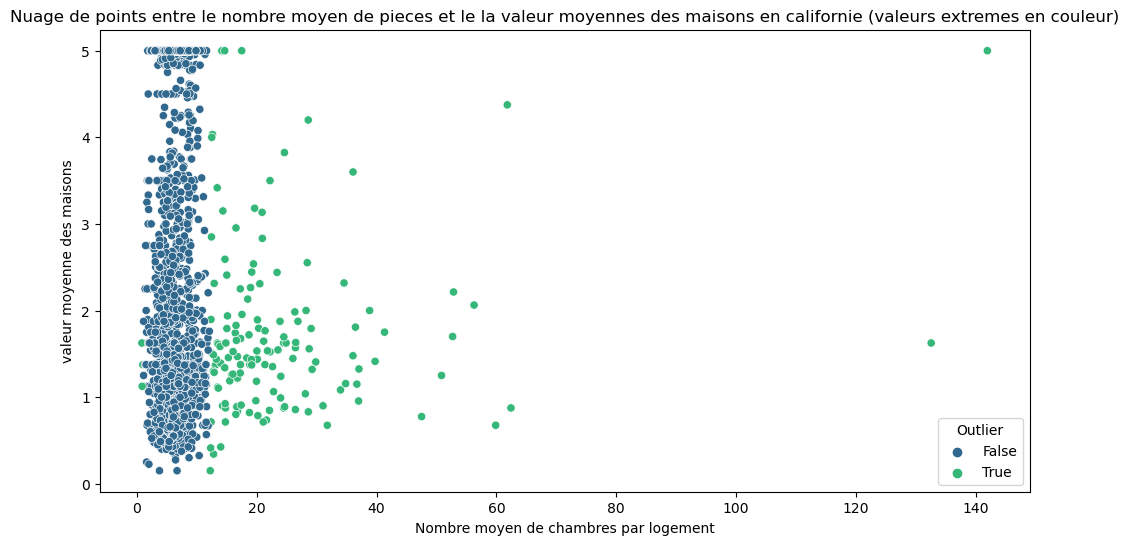

In [63]:
# Detecter les outliers pour les colonnes 'AveRooms' et 'median_house_value'
outliers_AveRoom = detect_outliers_iqr(data, 'AveRooms')
outliers_median_house_value = detect_outliers_iqr(data, 'median_house_value')

# Ajouter une colonne pour indiquer si la valeur est extreme
data['Outlier'] = False # Crée une nouvelle colonne appelée Outlier. Initialise toutes les lignes avec la valeur False (aucun outlier).
data.loc[outliers_AveRoom.index, 'Outlier'] = True # data.loc[...] : Sert à sélectionner des lignes par index.
data.loc[outliers_median_house_value.index, 'Outlier'] = True

# Creer un nuage de points (scatter plot) avec Seaborn en mettant en evidence les valeurs extremes
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='AveRooms', y='median_house_value', hue='Outlier', palette='viridis')
plt.xlabel('Nombre moyen de chambres par logement')
plt.ylabel('valeur moyenne des maisons')
plt.title('Nuage de points entre le nombre moyen de pieces et le la valeur moyennes des maisons en californie (valeurs extremes en couleur)')
plt.show()

### 5.2 Isolation Forest (On peut isoler les valeurs normales des valeurs aberrantes)

L'Isolation Forest est une méthode d'apprentissage automatique non supervisée pour identifier les valeurs aberrantes dans des données univariées et multivariées. Elle fonctionne en construisant plusieurs arbres de décision aléatoires et en calculant un score d'anomalie pour chaque observation en fonction de la profondeur moyenne à laquelle elle est isolée des autres observations.

### 5.2.1 Définition
L'Isolation Forest est basée sur l'idée que les valeurs aberrantes sont plus faciles à isoler que les valeurs normales. Elle construit plusieurs arbres de décision aléatoires et divise les données en sous-ensembles aléatoires à chaque nœud. L'algorithme isole les observations en fonction de la profondeur moyenne à laquelle elles sont isolées par rapport aux autres observations. Les observations qui sont isolées plus rapidement que la moyenne sont considérées comme des valeurs aberrantes.

### 5.2.2 Avantages
**L'Isolation Forest est capable de détecter les valeurs aberrantes dans des données univariées et multivariées. Elle fonctionne également bien avec des distributions non symétriques et est assez robuste aux valeurs aberrantes.**

### 5.2.3 Inconvénients
L'Isolation Forest peut être sensible aux paramètres tels que le nombre d'arbres et la taille des sous-échantillons. De plus, elle peut parfois être difficile à interpréter, en particulier pour les données multivariées.

In [55]:
# S'il y'avait des valeurs manquantes : 
# Dans la california, on a des valeurs à la difference de la base de données utilisées dans le tuto, Avec des valeurs
# manquantes, on ne peut pas implementer IsolationForest
print(f"Valeurs manquantes avant traitement :\n{data.isna().sum()}")

# Je fais le choix de les supprimer (les lignes avec des NaN (rapide, mais perte de données))
data = data.dropna()
print(f"Valeurs manquantes avant traitement :\n{data.isna().sum()}")



Valeurs manquantes avant traitement :
MedInc                    0
HouseAge                  0
AveRooms                  0
AveBedrms                 0
Population                0
AveOccup                  0
Latitude                  0
Longitude                 0
median_house_value        0
Outlier                   0
Outliers              18146
dtype: int64


In [65]:
from sklearn.ensemble import IsolationForest

# Appliquer l'Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_labels = iso_forest.fit_predict(data)

# Ajouter le labels d'anomalie au DataFrame
data['Outlier'] = outlier_labels

# Afficher les outliers
outliers = data[data['Outlier'] == -1]
print("Outliers détectés:")
print(outliers)

Outliers détectés:
        MedInc  HouseAge   AveRooms  AveBedrms  Population   AveOccup  \
73      0.4999      46.0   1.714286   0.571429        18.0   2.571429   
89      1.2434      52.0   2.929412   0.917647       396.0   4.658824   
270     3.8750      33.0   3.021277   0.659574       575.0  12.234043   
459     1.1696      52.0   2.436000   0.944000      1349.0   5.396000   
1024    3.1500      16.0  29.852941   5.323529       202.0   1.980392   
...        ...       ...        ...        ...         ...        ...   
20163  12.6320       5.0   7.462963   0.888889       208.0   3.851852   
20335   8.9063       5.0   8.944643   1.100893      4253.0   3.797321   
20352   4.0208       8.0   2.500000   0.625000       309.0  19.312500   
20427   8.6499       4.0   7.236059   1.032528      5495.0   2.553439   
20428   8.7288       6.0   8.715842   1.102970      3385.0   3.351485   

       Latitude  Longitude  median_house_value  Outlier Outliers  
73        37.81    -122.29           

### Solutions pour traiter les valeurs aberrantes

| **Type de valeur aberrantes** | Solutions pour les traiter |
| --- | --- |
| **Erreur :** | | 
| |1. Correction de l'erreur si possible (ex. erreurs de saisie) |
| | 2. Suppression de l'observation si la correction n'est pas possible et si l'erreur est clairement une anomalie | 
| | 3. Remplacer par une valeur manquante et imputer avec les techniques d'imputation |  
| **Extrême :** |  |
| | 1. Transformation des données (ex. logarithmique, racine carrée) pour réduire l'impact des valeurs extrêmes | 
| | 2. Winsorisation : remplacer les valeurs extrêmes par des percentiles spécifiques (ex. 1er et 99e percentiles) | 
| | 3. Utiliser des modèles d'apprentissage automatique robustes aux valeurs extrêmes (ex. modèles basés sur les rangs) | 
| | 4. Discrétiser la variable | 
| | 5. Faire le modèle avec et sans les valeurs extrêmes et analyser l'impact |
